### We'll create and run a RAG pipeline from scratch
- Specifically we would like to be able to open a PDF file, ask questions of it and have them answered by a Large Language Model (LLM)
- There are frameworks that replicates this kind of workflow, including LlamaIndex and LangChain, however, the goal of building from scratch is to be able to inspect and customize all the parts.

### Why RAG?

The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are incredible but they are prone to potential hallucination, as in, generating something that *looks* correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

The authors of the original RAG paper mentioned above outlined these two points in their discussion.

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data.


### What we're going to build:

We'll write the code to:
1. Open a PDF document (you could use almost any PDF here)
2. Format the text of the PDF textbook ready for an embedding model
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.

The above steps can be broken down into two major sections:
1. Document preprocessing/embedding creation(step1-3).
2. Search and answer(step 4-6).

### Setup

In [ ]:
import os

if "COLAB_GPU" in os.environ:
  print("[INFO] Running in Google Colab, installing requirements.")
  !pip install -U torch
  !pip install PyMuPDF # For reading pdf's with python
  !pip install tqdm # for progress bar
  !pip install sentence-transformers # for embedding models
  !pip install accelerate # for quantization model loading
  !pip install bitsandbytes # for quantizing model (less storage space)
  !pip install flash-attn --no-build-isolation # for faster attention mechanism - faster LLM inference
  !pip install bitsandbytes accelerate
  !pip install flash-attn
  !pip install -U "transformers==4.38.1" --upgrade
  !pip install accelerate
  !pip install -i https://pypi.org/simple/ bitsandbytes

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 1. Document/Text processing and embedding creation

- Import PDF Document

In [ ]:
# Download pdf file
import os
import requests

# Get pdf document
pdf_path = "human-nutrition-text.pdf"

# Download pdf if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File does not exist, downloading...")

  # The url of the pdf you want to download file
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a get request to the url
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
    # Open the file in binary write omde and save the content to it
    with open(filename, "wb") as file:
      file.write(response.content)
    print(f"The file has been downloaded and save as {filename}")
  else:
    print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File does not exist, downloading...
The file has been downloaded and save as human-nutrition-text.pdf


We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
  """Performs minor formatting on text."""
  cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

  # Other potential text formatting functions can go here
  return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  """
  Opens a PDF file, reads its text content page by page, and collects statistics.

  Parameters:
    pdf_path (str): This file path to the PDF document to be opened and read.

  Returns:
    list[dict]: A list of dictionaries, each containing the page number
    (adjusted), character count, word count, sentence count, token count, and the extracted text for each page.
  """
  doc = fitz.open(pdf_path) # open a document
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)): # iterate the document pages
    text = page.get_text() # get plain text encoded as UTF-8
    text = text_formatter(text)
    pages_and_texts.append({"page_number": page_number - 41, # adjust page numbers, since sample pdf starts on page 42
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text) / 4, # 1 token = ~4 chars
                            "text": text})
  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

### Get some stats on text

Many embedding models have limits on the size of texts they can ingest, for example, the sentence-transformers model all-mpnet-base-v2 has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the all-mpnet-base-v2 model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

Chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with text = text.split(". "), like we did above).
2. Split into sentences with a natural language processing (NLP) library such as spaCy or nltk.

In [ ]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however it's an open-source library designed to do NLP tasks like this at scale. So let's run our small sentencizing pipeline on our pages of text.

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure all sentences are strings
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
import random
random.sample(pages_and_texts, k = 1)

[{'page_number': 1003,
  'page_char_count': 1308,
  'page_word_count': 221,
  'page_sentence_count_raw': 13,
  'page_token_count': 327.0,
  'text': 'Giardia lamblia is another parasite that is found in contaminated  drinking water. In addition, it lives in the intestinal tracts of animals,  and can wash into surface water and reservoirs, similar to  Cryptosporidium. Giardia causes giardiasis, with symptoms that  include abdominal cramping and diarrhea within one to three days.  Although most people recover within one to two weeks, the disease  can lead to a chronic condition, especially in people with  compromised immune systems.  The  parasite  Toxoplasma  gondii  causes  the  infection  toxoplasmosis, which is a leading cause of death attributed to  foodborne illness in the United States. More than sixty million  Americans carry Toxoplasma gondii, but very few have symptoms.  Typically, the body’s immune system keeps the parasite from  causing disease. Sources include raw or undercoo

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


Now we've got our text split into sentences, how about we group those sentences

### Chunking our sentences together

In [ ]:
# Define split size to turn groups og sentences into chunks
num_sentences_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
               """
               Splits the input_list int sublists of size slice_size (or as close as possible).
               """
               return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through the pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
  item["sentence_chunks"] = split_list(input_list = item["sentences"],
                                       slice_size = num_sentences_chunk_size)
  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k = 1)

[{'page_number': 485,
  'page_char_count': 958,
  'page_word_count': 171,
  'page_sentence_count_raw': 6,
  'page_token_count': 239.5,
  'text': 'Photo by  Providence  Doucet on  unsplash.co m / CC0  https:/ /unspl ash.com/ photos/ 5za6niH4qp w  Factors Affecting Energy  Intake  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Physiology  In the last few decades scientific studies have revealed that how  much we eat and what we eat is controlled not only by our own  desires, but also is regulated physiologically and influenced by  genetics. The hypothalamus in the brain is the main control point of  appetite. It receives hormonal and neural signals, which determine  if you feel hungry or full. Hunger is an unpleasant sensation of  feeling empty that is communicated to the brain by both mechanical  and chemical signals from the periphery. Conversely, satiety is the  sensation of feeling full and it also is determined by mechanical  an

In [ ]:
# Create a dataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item
We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"]

    # Join the sentences together into a paragraph-like structure aka a chunk (so they are a single string)
    joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
    chunk_dict["sentence_chunk"] = joined_sentence_chunk

    # Get stats about the chunk
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

    pages_and_chunks.append(chunk_dict)

# How many chunks do we have
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 702,
  'sentence_chunk': 'Fluoride  Fluoridated  water, foods  prepared in  fluoridated  water,  seafood  3-4 mg/day  Component of  mineralized bone,  provides structure  and  microarchitecture,  stimulates new bone  growth  Increased risk  of dental  caries  Po w flu w Manganese  Legumes,  nuts, leafy  green  vegetables  1.8-2.3 mg/ day  Glucose synthesis,  amino-acid  catabolism  Impaired  growth,  skeletal  abnormalities,  abnormal  glucose  metabolism  N Molybdenum  Milk, grains,  legumes  45 mcg/day  Cofactor for a  number of enzymes  Unknown  N Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document). Learning activities may be used across various mobile  devices, however, for the best user experienc

In [ ]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,750.40,128.29,187.60
std,347.79,455.59,79.84,113.90
min,-41.00,14.00,4.00,3.50
25%,280.50,321.50,51.50,80.38
50%,586.00,764.00,131.00,191.00
75%,890.00,1138.00,194.00,284.50
max,1166.00,1870.00,412.00,467.50


Some of our chunks have quite a low token count

In [ ]:
# Show random chunks with under 30 token in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
  print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 22.5 | Text: http:/ /www.health.gov.fj/?page_id=1406. Accessed  November 12, 2017. 652  |  Introduction
Chunk token count: 16.75 | Text: PART XVII  CHAPTER 17. FOOD SAFETY  Chapter 17. Food Safety  |  985
Chunk token count: 7.5 | Text: Water-Soluble Vitamins  |  553
Chunk token count: 26.5 | Text: view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=306  484  |  Weight Management
Chunk token count: 10.75 | Text: Table 3.6 Salt Alternatives  186  |  Sodium


Most of these tokens don't seem to offer much information

Let's filter our dataFrame of dictionaries to only include chunks with over 30 tokens in length

In [ ]:
pages_and_chunks = df[df["chunk_token_count"] > min_token_length].to_dict(orient = "records")
pages_and_chunks[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

### Embedding our text chunks

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
%%time

# Create embeddins one by one on the gpu
for item in tqdm(pages_and_chunks):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1685 [00:00<?, ?it/s]

CPU times: user 36.2 s, sys: 208 ms, total: 36.4 s
Wall time: 46.8 s


That was fast, but many modern models can handle batched predictions.

This means computing on multiple samples at once.

Those are the type of operations where a GPU flourishes

We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]
text_chunks[:1]

['Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE']

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size = 32,
                                                convert_to_tensor = True)
text_chunk_embeddings

CPU times: user 20.5 s, sys: 35.6 ms, total: 20.5 s
Wall time: 22.7 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our pages_and_chunks_over_min_token_len list of dictionaries into a DataFrame and save it.

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index = False)

In [ ]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


### Similarity Search

Let's import our embeddings we created earlier and prepare them for use by turning them into a tensor

In [ ]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved as CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep = " "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient = "records")

# Convert embeddings to torch tensor and send to device (note: numpy array are float64 and torch tensor are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df["embedding"].tolist()), dtype = torch.float32).to(device)
embeddings.shape

torch.Size([1685, 768])

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = device)

Embedding model ready

Time to perform a semantic search

1. Define a query string (e.g. `"macronutrients functions"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

In [ ]:
# Define the query
# Note: This could be anything. But since we are working with a nutrition textbook, we'll stick with nutrition based queries.
query = "breastfeeding timeline"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query, convert_to_tensor = True)

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k = 5)
top_results_dot_product

Query: breastfeeding timeline
Time take to get scores on 1685 embeddings: 0.03636 seconds.


torch.return_types.topk(
values=tensor([0.6228, 0.6050, 0.5982, 0.5951, 0.5646], device='cuda:0'),
indices=tensor([1148, 1164, 1142, 1173, 1155], device='cuda:0'))

In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length = 80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

print(f"Query: '{query}'\n")
print("Results: ")
# Loop through zipped togehter scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f"Score: {score:.4f}")
  # Print relevant sentences chunk
  print("Text:")
  print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
  # Print the page number too so we can reference the textbook further (and check the result)
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'breastfeeding timeline'

Results: 
Score: 0.6228
Text:
child is 1 year old.7 See: https:/ /wicworks.fns.usda.gov/resources/ 50-state-
summary-breastfeeding-laws  Everyday Connection  In the Pacific, the state of
Hawai‘i and and the territory of  Guam are mandated to provide several
accommodations  within the workplace for new mothers. All employers are to
required to allow breastfeeding mothers adequate break  time to pump or nurse in
location other than a bathroom. To learn more about Hawai‘i’s laws visit  http:/
/health.hawaii.gov/wic/files/2013/04/ WorkplaceBreastfeeding_02_2014.pdf and for
Guam’s laws  visit  http:/ /www.guamcourts.org/CompilerofLaws/GCA/
10gca/10gc092A.pdf. Members of a community can also promote and support
breastfeeding. New mothers can join peer counseling groups or  turn to other
women within their community who have previous  experience with breastfeeding.
In addition, community-based  programs can provide education and support. The US
Department  of 

How about we check the page to verify?

We can do so by loading the page number containing the highest result.

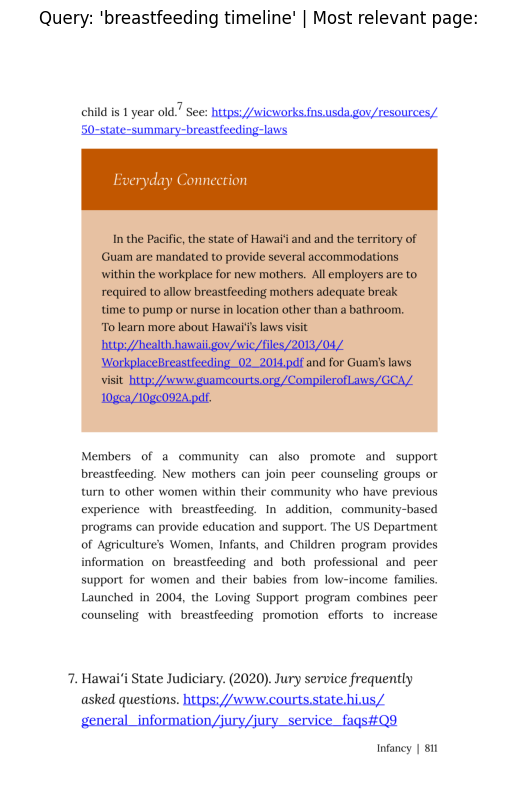

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(811 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()


### The workflow

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

### Functionizing our semantic search pipeline

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Now let's test our function out.

In [ ]:
query = "symptoms of pellagra"

# Print out the text of the top score
print_top_results_and_scores(query = query,
                             embeddings = embeddings)

[INFO] Time taken to get scores on 1685 embeddings: 0.00007 seconds.
Query: symptoms of pellagra

Results: 
Score: 0.6228
child is 1 year old.7 See: https:/ /wicworks.fns.usda.gov/resources/ 50-state-
summary-breastfeeding-laws  Everyday Connection  In the Pacific, the state of
Hawai‘i and and the territory of  Guam are mandated to provide several
accommodations  within the workplace for new mothers. All employers are to
required to allow breastfeeding mothers adequate break  time to pump or nurse in
location other than a bathroom. To learn more about Hawai‘i’s laws visit  http:/
/health.hawaii.gov/wic/files/2013/04/ WorkplaceBreastfeeding_02_2014.pdf and for
Guam’s laws  visit  http:/ /www.guamcourts.org/CompilerofLaws/GCA/
10gca/10gc092A.pdf. Members of a community can also promote and support
breastfeeding. New mothers can join peer counseling groups or  turn to other
women within their community who have previous  experience with breastfeeding.
In addition, community-based  program

### Connecting an LLM for generation

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

# # But for now I wonna try the biggest model so...
# model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
!pip install bitsandbytes
!pip install flash-attn
# 1. Create quantization config for smaller model loading
# Require !pip install bitsandbytes accelerate (only do this if you have low gpu memory)
# For model that requires 4-bit quantization (use this if you low gpu memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit = True,
                                         bnb_4bit_compute_dtype = torch.float16)

# Setup flash attention 2 for faster inference, default to "sdpa" or "scaled dot product attention"
# Requires !pip install flash-attn
# if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 0):
#   attn_implementation = "flash_attention_2"
# else:
attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a mode we'd like to use
model_id = model_id
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path = model_id,
                                                 torch_dtype = torch.float16,
                                                 quantization_config = quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage = True,
                                                 attn_implementation = attn_implementation)

if not use_quantization_config:
  llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We've got an LLM
Let's check it out

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

Let's get the number of parameters in our model

In [ ]:
def get_model_num_params(model: torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

Let's see the model memory requirements

In [ ]:
def get_model_mem_size(model: torch.nn.Module):

  # Get the model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

  # Calculate various model sizes
  model_mem_bytes = mem_params + mem_buffers # in bytes
  model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
  model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

  return {"model_mem_bytes": model_mem_bytes,
          "model_mem_mb": round(model_mem_mb, 2),
          "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5549215744, 'model_mem_mb': 5292.14, 'model_mem_gb': 5.17}

### Let's try conversating with it

In [ ]:
input_text = "What are the macronutrients?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235336,    107,    108,    106,   2516,    108,  21404, 235269,
          1517, 235303, 235256,    476,  25497,    576,    573, 186809, 184592,
        235292,    109,    688, 156615,  56227,  66058,    109, 235287,  34428,
           573,   2971,    675,   4134,    578,    708,    573,   7920,   4303,
           576,   9719,    604,   1546,   5999, 235265,    108, 235287,   7272,
           575,  16512,   1154,  11843, 235269,  22512, 235269,  12463, 235269,
         25741, 235269,    578,  16803, 235265,    109,    688, 216954,  66058,
           109, 235287,   810

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients:

**Carbohydrates:**

* Provide the body with energy and are the primary source of fuel for most cells.
* Found in foods like bread, pasta, rice, potatoes, and fruits.

**Proteins:**

* Build and repair tissues, produce enzymes, hormones, and antibodies.
* Found in foods like meat, fish, eggs, legumes, nuts, and seeds.

**Fats:**

* Provide energy and insulation.
* Found in foods like oil, butter, cheese, nuts, and seeds.

**Macronutrient Ratio:**

The recommended macronutrient ratio is 45-65% carbohydrates, 30-50% protein, and 20-35% fat. This ratio can be adjusted based on individual needs and goals.

**Macronutrient Intake:**

* The average adult should consume a balanced diet that provides these essential nutrients in appropriate proportions.
* It's recommended to consult with a healthcare professional or registered diet

### Since it seems to be working, now we can implement the entire pipeline

In [ ]:
import random
query = "What are macronutrients"

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are macronutrients
[INFO] Time taken to get scores on 1685 embeddings: 0.00008 seconds.


(tensor([0.7382, 0.6397, 0.5957, 0.5430, 0.5155], device='cuda:0'),
 tensor([42, 46, 47, 41, 56], device='cuda:0'))

### Now let's augment our prompt with context items

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
  # Join context items into one dotted paragraph
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

  base_prompt = """While answering the query that I have asked below, I would like you to also take in consideration the context that i provide:
Context: {context}
Query: {query}
                """

  # Update base prompt with context items and query
  base_prompt = base_prompt.format(context = context, query = query)

  # Create prompt template for instruction-tuned model
  dialogue_template = [
      {
          "role": "user",
          "content": base_prompt
      }
  ]

  # Apply the chat template
  prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                         tokenize = False,
                                         add_generation_prompt = True)

  return prompt

In [ ]:
query = "What are macronutrients?"
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query = query,
                          context_item = context_items)

print(prompt)

Query: What are macronutrients?
[INFO] Time taken to get scores on 1685 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
While answering the query that I have asked below, I would like you to also take in consideration the context that i provide:
Context: - Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients. There are three classes of macronutrients:  carbohydrates, lipids, and proteins. These can be metabolically  processed into cellular energy. The energy from macronutrients  comes from their chemical bonds. This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions. A unit of  measurement of food energy is the calorie. On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a 

### Let's tokenize this and pass it straight to our LLM

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature = 0.7,
                             do_sample = True,
                             max_new_tokens = 256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer: \n{output_text.replace(prompt, '')}")

Query: What are macronutrients?
RAG answer: 
<bos>Sure, here's the answer to your query:

Macronutrients are nutrients that are needed in large amounts in the body and can be metabolically processed into cellular energy. They are categorized into three classes: carbohydrates, lipids, and proteins.<eos>
CPU times: user 2.72 s, sys: 10.7 ms, total: 2.73 s
Wall time: 3.46 s


### Let's functionize the generation step

In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
# print(f"Context items:")
# context_items

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1685 embeddings: 0.00008 seconds.
Answer:

Sure, here's a comprehensive explanation of the concept of energy balance and
its importance in weight management:  **Energy Balance**  Energy balance refers
to the state of equilibrium between energy intake and expenditure. When energy
intake is equal to energy expenditure, body weight is maintained. This state is
crucial for various physiological processes, including metabolism, growth,
repair, and reproduction.  **Importance of Energy Balance for Weight
Management**  Maintaining energy balance is essential for weight management.
When energy intake exceeds expenditure, excess energy is stored as fat. This can
lead to weight gain and increased risk of obesity-related diseases. Conversely,
when energy intake is less than expenditure, the body uses stored energy sources
to maintain body weight. This can lead to weight loss, m